In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.modeling_helpers import ModelHelper
from sklearn.linear_model import LinearRegression, LogisticRegression


from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]

loader.initial_setup()
loader.add_tag_intensity_score()
prepared_df = loader.add_gender_code(loader.prepared_df)
tag_columns = loader.tag_cols
prepared_df.columns

tag_intensity_score = loader.find_agg_tag_columns("tag_intensity_score")
loader.add_column_zscores_standardized(columns = tag_intensity_score)
z_score_cols = loader.find_agg_tag_columns("zscore_tag_intensity_")
z_score_cols

prepared_df = loader.prepared_df

MODEL_HELPER = ModelHelper(df=prepared_df, random_seed=SEED)


Using seed: 18787288


In [2]:
#  Build a regression model predicting average rating from all numerical predictors (the ones in the 
# rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these 
# factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns. 

prepared_df["avg_rating"].describe()

count    52088.000000
mean         3.845847
std          1.115058
min          1.000000
25%          3.100000
50%          4.200000
75%          4.800000
max          5.000000
Name: avg_rating, dtype: float64

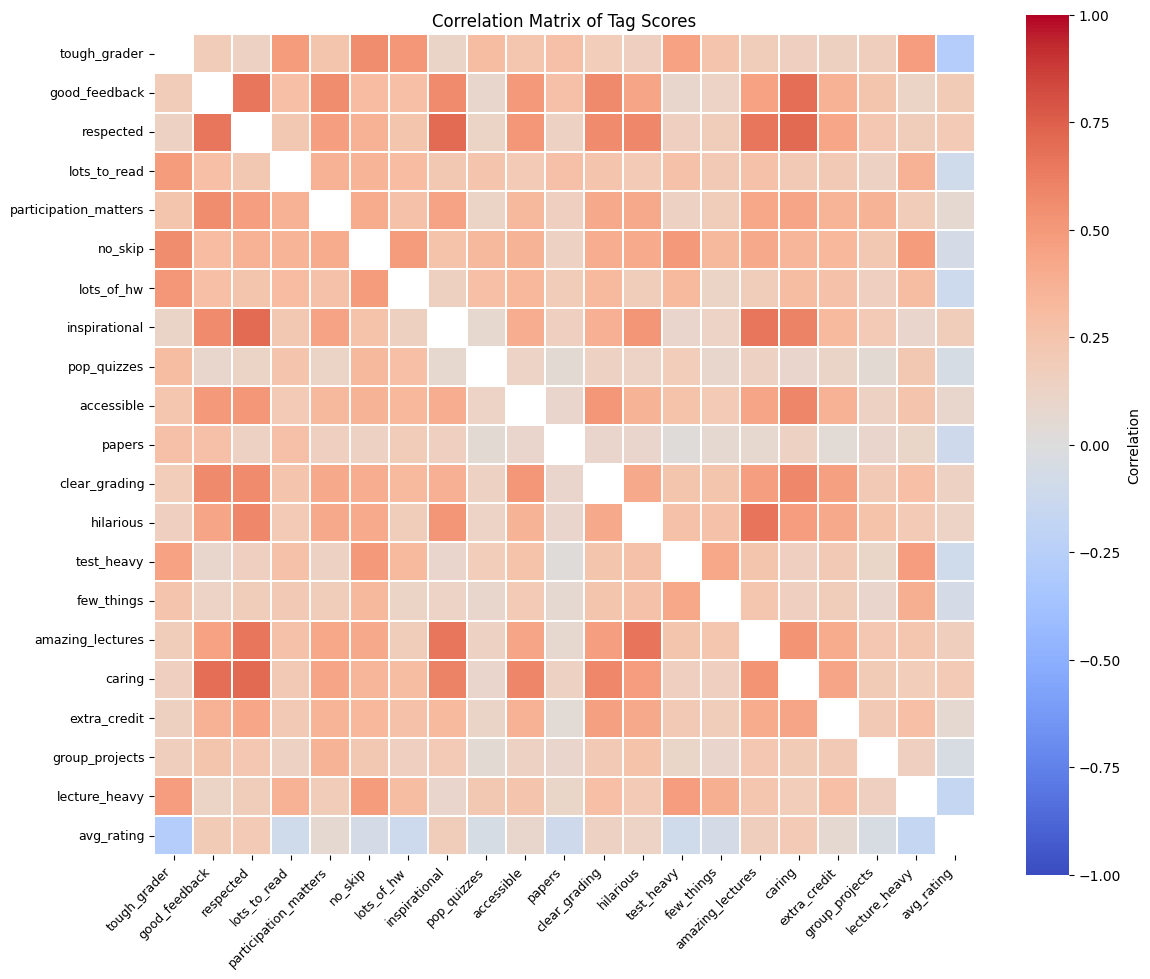

In [3]:
tag_cols = tag_columns + ["avg_rating"]
corr_matrix = prepared_df[tag_cols].corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    fmt="",
    cbar_kws={"label": "Correlation"}
)


plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("Correlation Matrix of Tag Scores")
plt.tight_layout()
plt.show()



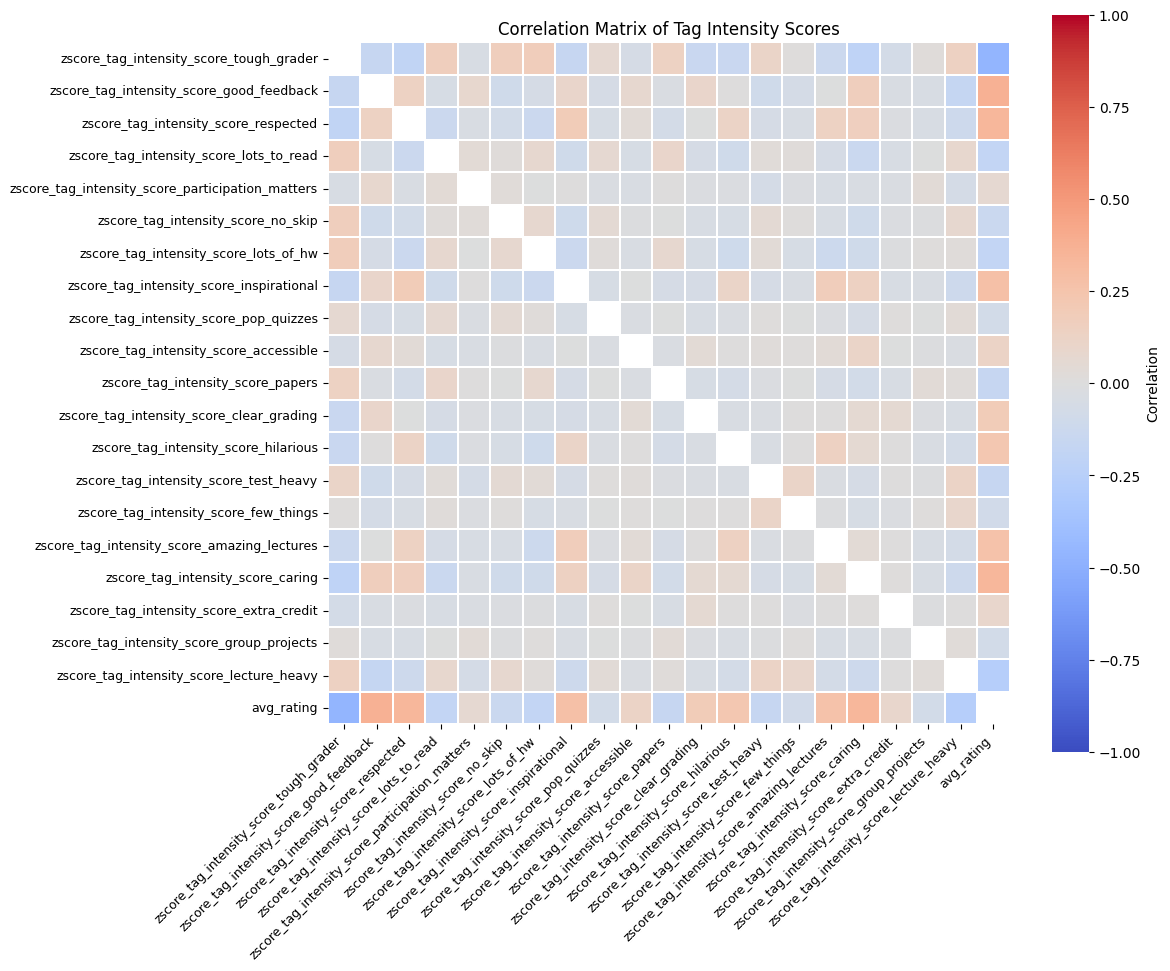

In [4]:
tag_cols = z_score_cols + ["avg_rating"]
corr_matrix = prepared_df[tag_cols].corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    fmt="",
    cbar_kws={"label": "Correlation"}
)


plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("Correlation Matrix of Tag Intensity Scores")
plt.tight_layout()
plt.show()



In [14]:
corr_with_y = corr_matrix["avg_rating"].abs().sort_values(ascending=False)
selected_features = corr_with_y[corr_with_y > 0.15].index.drop("avg_rating")
X_reduced = prepared_df[selected_features]

print(selected_features)

k_folds = MODEL_HELPER.kfold_split()

model=LinearRegression()

MODEL_HELPER.cross_val_score(
    model,
    X=X_reduced,
    y=prepared_df["avg_rating"],
    kfolds=k_folds,
    scoring_methods=["rmse", "r2", "mae"]
)

Index(['zscore_tag_intensity_score_tough_grader',
       'zscore_tag_intensity_score_good_feedback',
       'zscore_tag_intensity_score_respected',
       'zscore_tag_intensity_score_caring',
       'zscore_tag_intensity_score_inspirational',
       'zscore_tag_intensity_score_amazing_lectures',
       'zscore_tag_intensity_score_lecture_heavy',
       'zscore_tag_intensity_score_hilarious',
       'zscore_tag_intensity_score_clear_grading',
       'zscore_tag_intensity_score_lots_of_hw',
       'zscore_tag_intensity_score_lots_to_read',
       'zscore_tag_intensity_score_test_heavy',
       'zscore_tag_intensity_score_papers'],
      dtype='object')


defaultdict(list,
            {'rmse': [0.800159419934298,
              0.8075826784980132,
              0.8014823655986519,
              0.8042569772589168,
              0.7857229095595684],
             'r2': [0.4922700606273671,
              0.4811794618890436,
              0.4770420093657475,
              0.4834304742575055,
              0.4930318906556417],
             'mae': [0.6024317303372125,
              0.6119424964067557,
              0.6068933272335814,
              0.6054343321922482,
              0.5904242718814527]})

In [16]:
coefs = pd.Series(
    model.coef_,  # or pipeline.named_steps["lr"].coef_
    index=selected_features
).sort_values(key=np.abs, ascending=False)

coefs.head()


zscore_tag_intensity_score_tough_grader       -0.283446
zscore_tag_intensity_score_good_feedback       0.253467
zscore_tag_intensity_score_caring              0.181240
zscore_tag_intensity_score_respected           0.176085
zscore_tag_intensity_score_amazing_lectures    0.168697
dtype: float64